In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [3]:
class galerkin_bim:
    def __init__(self, n, a, b, lam, x1, x2, rhs):
        
        self.n = n
        self.a = a
        self.b = b
        self.lam = lam
        
        self.t = sp.Symbol('t')
        self.s = sp.Symbol('s')
        self.x1 = x1(self.s)
        self.x2 = x2(self.s)
        self.y1 = x1(self.t)
        self.y2 = x2(self.t)
        
        # initialize h for quadrature to find u
        self.h = (b-a) / n
        
        # initialize arrays
        self.matrix = np.zeros((n+1,n+1))
        self.rhs_values = np.zeros(n+1)
        self.mu = np.zeros(n+1)
        self.u = np.zeros(n+1)
        
        # initialize everything else
        self.rhs = rhs.subs({q:self.y1,r:self.y2})
        self.jacobian_lam = 0
        self.dgreens_dn_lam = 0
        self.kappa_lam = 0
        
    
    def lagrange_poly_value(self, n_in, i, t_in):
        # evaluates the ith Lagrange polynomial on [a,b] with n_in nodes at the point t_in
        h_in = (self.b - self.a) / n_in
        #self.lagrange_poly = 0
        #self.lagrange_poly_lam = 0
        
        if (i != 0 and i != n_in):
            self.lagrange_poly = sp.Piecewise((0, self.t < self.a + (i-1) * h_in), (0, self.t > self.a + (i+1)*h_in), (1 - (sp.Abs(self.t - (self.a + i*h_in))/h_in),True))
            self.lagrange_poly_lam = sp.lambdify(self.t,self.lagrange_poly)
        if (i == 0):
            self.lagrange_poly = sp.Piecewise((0,self.t > self.a + (i+1)*h_in),(1 - (sp.Abs(self.t - (self.a + i*h_in))/h_in),True))
            self.lagrange_poly_lam = sp.lambdify(self.t,self.lagrange_poly)
        if (i == n_in):
            self.lagrange_poly = sp.Piecewise((0,self.t < self.a + (i-1)*h_in),(1 - (sp.Abs(self.t - (self.a + i*h_in))/h_in),True))
            self.lagrange_poly_lam = sp.lambdify(self.t,self.lagrange_poly)
        
        return self.lagrange_poly_lam(t_in)
    
    
    def get_t_values(self,n_in):
        # values at which a solution will be evaluated at (correspond to composite trapezoid nodes)
        t_values = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        for i in range(0,n_in + 1):
            t_values[i] = self.a + i*h_in
        
        return t_values

            
    def get_trap_weights(self,n_in):
        # weights for composite trapezoid rule, which is used to evaluate u
        weights = np.zeros(n_in + 1)
        h_in = (self.b - self.a) / n_in
        weights[0] = 0.5
        weights[n_in] = 0.5
        for i in range(1,n_in):
            weights[i] = 1
        weights = weights * h_in;
        
        return weights
        
        
    def construct_greens_function(self):
        # build all necessary functions
        # first the Jacobian
        self.jacobian = sp.sqrt(sp.Pow(sp.diff(self.y1,self.t),2) + sp.Pow(sp.diff(self.y2,self.t),2))
        self.jacobian_lam = sp.lambdify(self.t,self.jacobian)

        # normal vector in 2D
        self.normal = (1/self.jacobian) * sp.Array([-1*sp.diff(self.y2,self.t),sp.diff(self.y1,self.t)])

        # greens function and normal derivative
        self.greens_fxn = (1/(2*np.pi)) * sp.log(sp.sqrt(sp.Pow(self.x1 - self.y1,2) + sp.Pow(self.x2 - self.y2,2)))
        self.del_greens_fxn = sp.Array([-1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x1-self.y1),
                                        -1*(1/(2*np.pi))*(1/(sp.Pow(self.x1-self.y1,2) + sp.Pow(self.x2-self.y2,2))) * (self.x2-self.y2)])
        self.dgreens_dn = self.del_greens_fxn[0] * self.normal[0] + self.del_greens_fxn[1] * self.normal[1]
        self.dgreens_dn_simplified = sp.simplify(self.dgreens_dn)
        self.dgreens_dn_lam = sp.lambdify([self.t,self.s],self.dgreens_dn_simplified)
        # order for inputs is (t,s)

        # for the case where the kernel is nearly singular
        self.kappa = (-1/(4*np.pi))*(sp.diff(self.y2,self.t,self.t)*sp.diff(self.y1,self.t)-sp.diff(self.y1,self.t,self.t)*sp.diff(self.y2,self.t))*(1/(sp.Pow(sp.diff(self.y1,self.t),2)+sp.Pow(sp.diff(self.y2,self.t),2)))
        self.kappa_lam = sp.lambdify(self.t,self.kappa)
        
            
    def build_linear_system(self):
        # build matrix and rhs
        
        # define the grid
        t_values = self.get_t_values(self.n)
        
        # first build the rhs
        # this is the function y defined symbolically
        y_lam = sp.lambdify(self.t,self.rhs)
        
        self.rhs_values[0] = 0.5 * self.h * y_lam(self.a)
        self.rhs_values[self.n] = 0.5 * self.h * y_lam(self.b)
        for i in range(1, self.n):
            self.rhs_values[i] = self.h * y_lam(t_values[i])
        
        # next build the matrix, build the two parts separately and adding them together in the end
        
        # build the lam(li,lj) part first
        matrix_1 = np.zeros((self.n+1,self.n+1))
        for i in range(0,self.n + 1):
            for j in range(0,self.n + 1): 
                if (sp.Abs(i-j) > 1):
                    matrix_1[i,j] = 0
                elif (i == j and i > 0 and i < self.n):
                    matrix_1[i,j] = (2/3)*self.h
                elif (i == j and i == 0):
                    matrix_1[i,j] = (1/3)*self.h
                elif(i == j and i == self.n):
                    matrix_1[i,j] = (1/3)*self.h
                else:
                    matrix_1[i,j] = (1/6)*self.h
                    
        matrix_1 = matrix_1 * self.lam
        
        # now build the matrix of the double integral term
        # values of the integrals of the Lagrange polynomials
        L_vec = np.zeros(self.n + 1)
        L_vec[0] = 0.5
        L_vec[self.n] = 0.5
        for i in range(1,self.n):
            L_vec[i] = 1
        
        L_vec = L_vec * self.h
        
        gf = 1/(4*np.pi)
        matrix_2 = gf * np.outer(L_vec,L_vec)
        
        # combine the matrices
        self.matrix = matrix_1 - matrix_2
        
    def solve_mu(self):
        # solve the linear system for mu
        self.mu = np.linalg.inv(self.matrix)@self.rhs_values
        return self.mu
    
        

In [4]:
q,r = sp.symbols("q r")

# q,r are dummy variables for x1 and x2
rhs = sp.exp(q)*sp.cos(r)
N = 100

a = 0
b = 2*np.pi
lam = -0.5

x1 = sp.cos
x2 = sp.sin

gal = galerkin_bim(N, a, b, lam, x1, x2, rhs)
gal.build_linear_system()
mu = gal.solve_mu()


In [5]:
m = (mu.shape)             
m = m[0]

weights = gal.get_trap_weights(N)
mu_t = 0
for i in range(0,N+1):
        mu_t = mu_t + (weights[i] * mu[i] * (-1/ (4*np.pi)))

t_values = gal.get_t_values(N)
mu_s = np.zeros(N+1)
rhs_e = np.zeros(N+1)

for i in range(0,N+1):
    mu_s[i] = lam*mu[i] + mu_t
    rhs_e[i] = np.exp(np.cos(t_values[i]))*np.cos(np.sin(t_values[i]))
    
error_mu = np.zeros(N+1)
for i in range(0,N+1):
    error_mu[i] = np.abs( mu_s[i] - rhs_e[i] )

twoerror_mu = np.linalg.norm(error_mu)
#print(twoerror_mu)

inferror_mu = np.linalg.norm(error_mu,np.inf)
print(inferror_mu)    

#print(mu_s)
#print(rhs_e)

#print(t_values)
#print(weights)
#print(error_mu)
#plt.plot(error_mu)


0.0035859572729117772


Text(0, 0.5, 'left-hand side')

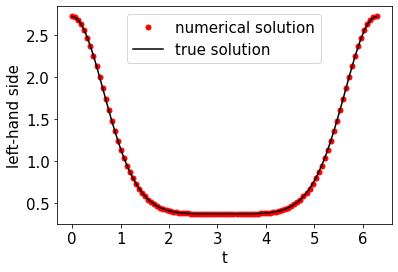

In [6]:
plt.rcParams.update({'font.size': 15})
p1 = plt.plot(t_values, mu_s, 'ro',markersize = 5, label = 'numerical solution')
p2 = plt.plot(t_values, rhs_e, 'k-', label = 'true solution')
plt.legend()
plt.xlabel('t')
plt.ylabel('left-hand side')

In [25]:
gal.construct_greens_function()
new_dgreens_dn = gal.dgreens_dn.subs({gal.x1:q, gal.x2: r})
new_dgreens_dn = sp.simplify(new_dgreens_dn)
new_dgreens_dn

0.159154943091895*(q*cos(t) + r*sin(t) - 1)/((q - cos(t))**2 + (r - sin(t))**2)

In [26]:
# solve for u
m = (mu.shape)             
m = m[0]
h = gal.h
t = gal.t
lam_dgreens_dn = sp.lambdify(t,new_dgreens_dn)

In [27]:
weights = gal.get_trap_weights(N)
u = 0
for i in range(0,N+1):
        u = u + (weights[i] * mu[i] * lam_dgreens_dn(h*i))

u_lam = sp.lambdify([q,r],u)
true_soln = sp.lambdify([q,r],rhs)

print(u_lam(0,0))
print(true_soln(0,0))

0.9999999999999974
1.0


In [28]:
b = 30
error = np.zeros(b)
db = 1/30
for i in range(0,b):
    error[i] = np.abs(  u_lam(i*db*1, db*0) - true_soln(i*db*1,db*0)   )

[2.55351296e-15 1.46451858e-06 3.12601773e-06 4.99948112e-06
 7.10079420e-06 9.44679197e-06 1.20553090e-05 1.49452320e-05
 1.81365547e-05 2.16504359e-05 2.55092594e-05 2.97366981e-05
 3.43577799e-05 3.93989577e-05 4.48881821e-05 5.08549782e-05
 5.73305254e-05 6.43477416e-05 7.19413709e-05 8.01480758e-05
 8.90065334e-05 9.85575367e-05 1.08844100e-04 1.19911570e-04
 1.31807741e-04 1.44582976e-04 1.58290336e-04 1.72985709e-04
 1.88727958e-04 2.11312278e-04]


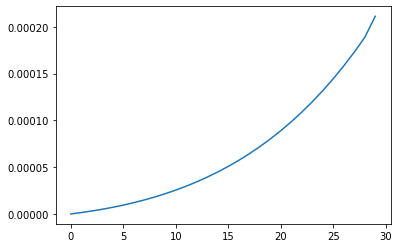

In [29]:
print(error)
plt.plot(error)

In [30]:
twoerror = np.linalg.norm(error)
print(twoerror)

inferror = np.linalg.norm(error,np.inf)
print(inferror)

0.0004966171980409388
0.0002113122777922527
